# NNW-Übung 3

In den Aufgabenstellung unten werden Sie aufgefordert Ihre Ergebnisse zu protokollieren. Legen Sie dafür mit einem Textverarbeitungssystem Ihrer Wahl ein einfaches Dokument an.

## 1 Mehrere Klassen
Ziel dieser Aufgabe ist, mehrere Klassen mittels eines Single-Layer Networks zu trennen. Als Beispieldaten sollen wieder die Iris-Daten dienen, wobei jetzt alle drei Iris Arten verwendet werden.

### a)
Für die Konvertierung der mit der Klassennummer kodierten Zieldaten `T` (also z.B. Klasse 2) in die one-hot-Codierung für ein Netz (also im Beispiel [0; 1; 0]) können Sie die folgende Funktion zu Ihrer Klasse `SLN` hinzufügen:

```python
def onehot(self,T):
    e=np.identity(self._W.shape[0])
    return e[:,T.astype(int)]
```
In der Funktion wird eine Einheitsmatrix (`np.identity(c)`) indiziert mit dem colon-Operator (`:`) und dem ursprünglichen Vektor der Zieldaten, der die Nummer der Klasse (Iris-Art) enthält.
Probieren Sie die Funktion zuerst für einen kleinen Zieldatenvektor `T=[0,2,1,2]` aus und vollziehen Sie sie nach.

In [1]:
import numpy as np
import copy

In [2]:
# based on: https://github.com/eakbas/tf-svm/blob/master/plot_boundary_on_data.py
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors


def plotTwoFeatures(X,T,pred_func):
    if X.ndim!=2:
        raise ValueError('X be a matrix (2 dimensional array).')
#    if X.shape[0]!=2: 
#        X=X.T
    if X.shape[0]!=2:
        raise ValueError('X must contain exactly 2 features.')
        
    # determine canvas borders
    mins = np.amin(X,1); 
    mins = mins - 0.1*np.abs(mins);
    maxs = np.amax(X,1); 
    maxs = maxs + 0.1*maxs;

    ## generate dense grid
    xs,ys = np.meshgrid(np.linspace(mins[0],maxs[0],300), 
            np.linspace(mins[1], maxs[1], 300));


    # evaluate model on the dense grid
    try:
        Z = pred_func(np.c_[xs.flatten(), ys.flatten()].T);
    except:
        Z = pred_func(np.c_[xs.flatten(), ys.flatten()]);
        
    if Z.ndim>1 and Z.shape[0]>1: # onehot? -> convert
        Z=Z.argmax(0)
    Z = Z.reshape(xs.shape)
    
    if T.ndim>1 and T.shape[0]>1: # onehot? -> convert
        T=T.argmax(0)
        
    # Plot the contour and training examples
    plt.contourf(xs, ys, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[0,:], X[1,:], c=T, s=50,
            cmap=colors.ListedColormap(['orange', 'blue', 'green']))
    plt.show()


In [3]:
def ErrorRate(Y,T):
    if Y.ndim==1 or Y.shape[0]==1:
        errors=Y!=T
        return errors.sum()/Y.size
    else: # für mehrere Ausgaben in one-hot Kodierung:
        errors=Y.argmax(0)!=T.argmax(0)
        return errors.sum()/Y.shape[1]

In [4]:
import matplotlib.pyplot as plt

class SLN:
    def __init__(self,dIn,cOut): # Konstruktor
        self._b=np.zeros(cOut)[np.newaxis].T
        np.random.seed(42)
        self._W=np.random.randn(cOut,dIn)/np.sqrt(dIn+1)
        
    def neuron_mit_for(self,X):
        net=np.zeros(X.shape[1])
        for n in range(0,X.shape[1]):
            for j in range(0,X.shape[0]):
                net[n]+=self._W[j]*X[j,n]
        net+=self._b;
        return net>=0
    
    def neuron(self,X):
        net=self._W.dot(X)+self._b
        return net>=0
    
    def DeltaTrain(self, X, T, eta, maxIter, maxErrorRate):
        best = self;
        bestError = 2;
        bestIt = 0;
        N=X.shape[1]    # Anzahl Trainingsdaten
        x0 = np.ones(N)[np.newaxis]
        plt.ion() # interactive mode on
        for it in range(maxIter):
            Y = self.neuron(X)
            err = ErrorRate(Y, T)
            if (it%20) == 0:
                print('#{} {} {} {}'.format(it,self._W,self._b,err))
                plotTwoFeatures(X,T,self.neuron)
                #älteres python: plt.pause(0.05) # warte auf GUI event loop
            if err<bestError:
                bestError = err
                best = copy.copy(self)
                bestIt = it
            if err <= maxErrorRate:
                break
            self._W+=eta*(T-Y).dot(X.T)/N
            self._b+=eta*(T-Y).dot(x0.T)/N
        self._W=best._W
        self._b=best._b
        print('#{} {} {} {}'.format(bestIt,self._W,self._b,err))
        plotTwoFeatures(X,T,self.neuron)
        #älteres python: plt.pause(0.05) # warte auf GUI event loop
        return bestError, bestIt
    
    def onehot(self,T):
        e=np.identity(self._W.shape[0])
        return e[:,T.astype(int)]

In [5]:
T=np.array([0,2,1,2])

sln = SLN(0,3)
e = sln.onehot(T)
print(e)

[[1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 1.]]


### b)
Wie in der Vorlesung besprochen, soll die Zuordnung zu der Klasse erfolgen, deren zugehöriges Output-Neuron den größten Wert geliefert hat (siehe 03_Grundkonzepte, Folie 55<sup>1</sup>  und 02_Aufgabenstellung, Folie 18 "one hot vectors"). Beispiel: `[0:2; 0:6; 0:5]` wird der Klasse 1 (Zählung ab 0) zugeordnet. Nützliche NumPy-Methode hierfür: `argmax`

Ergänzen Sie die Klasse `SLN` wie folgt und vollziehen Sie den Code nach:

```python
def __init__(self,dIn,cOut): # Konstruktor
    self._b=np.zeros(cOut)[np.newaxis].T
    np.random.seed(42)
    self._W=np.random.randn(cOut,dIn)/np.sqrt(dIn)
    if cOut==1:
        self.neuron=self.theshold
    else:
        self.neuron=self.thresholdMult
def netsum(self,X):
    return self._W.dot(X)+self._b
def theshold(self,X):
    return self.netsum(X)>=0
```

Implementieren Sie in der Klasse SLN eine Methode `thresholdMult(self,X)`, die die Netzwerksumme mit Hilfe von netsum berechnet und ein one-hot-kodiertes Ergebnis liefert.

In [6]:
import matplotlib.pyplot as plt

class SLN:
    def __init__(self,dIn,cOut): # Konstruktor
        self._b=np.zeros(cOut)[np.newaxis].T
        np.random.seed(42)
        self._W=np.random.randn(cOut,dIn)/np.sqrt(dIn)
        if cOut==1:
            self.neuron=self.theshold
        else:
            self.neuron=self.thresholdMult
        
    def netsum(self,X):
        return self._W.dot(X)+self._b
    def theshold(self,X):
        return self.netsum(X)>=0
    
    def thresholdMult(self,X):
        return self.onehot(self.netsum(X).argmax(0))
    
    def onehot(self,T):
        e=np.identity(self._W.shape[0])
        return e[:,T.astype(int)]
        
    def neuron_mit_for(self,X):
        net=np.zeros(X.shape[1])
        for n in range(0,X.shape[1]):
            for j in range(0,X.shape[0]):
                net[n]+=self._W[j]*X[j,n]
        net+=self._b;
        return net>=0
    
    def neuron(self,X):
        net=self.netsum(X)
        return net>=0
    
    def DeltaTrain(self, X, T, eta, maxIter, maxErrorRate):
        best = self;
        bestError = 2;
        bestIt = 0;
        N=X.shape[1]    # Anzahl Trainingsdaten
        x0 = np.ones(N)[np.newaxis]
        plt.ion() # interactive mode on
        for it in range(maxIter):
            Y = self.neuron(X)
            err = ErrorRate(Y, T)
            if (it%20) == 0:
                print('#{} {} {} {}'.format(it,self._W,self._b,err))
                plotTwoFeatures(X,T,self.neuron)
                #älteres python: plt.pause(0.05) # warte auf GUI event loop
            if err<bestError:
                bestError = err
                best = copy.copy(self)
                bestIt = it
            if err <= maxErrorRate:
                break
            self._W+=eta*(T-Y).dot(X.T)/N
            self._b+=eta*(T-Y).dot(x0.T)/N
        self._W=best._W
        self._b=best._b
        print('#{} {} {} {}'.format(bestIt,self._W,self._b,err))
        plotTwoFeatures(X,T,self.neuron)
        #älteres python: plt.pause(0.05) # warte auf GUI event loop
        return bestError, bestIt

### c)
Trainieren Sie ein Single-Layer Network für die Unterscheidung aller drei Iris-Arten mit der Funktion `SlnDeltaTrain`.

Verwenden Sie dazu die Merkmale/Attribute 3 und 4!

Übernehmen Sie den Plot in die Auswertung und geben Sie zudem an: den von Ihnen gewählten Wert für η, die erreichte Fehlerrate und nach wievielen Iterationsschritten diese Fehlerrate _erstmalig_ erreicht wurde.

Anmerkung zur Interpretation des Ergebnisses: Die Daten sind nicht linear separabel!

#0 [[ 0.35122995 -0.09776762]] [[0.]] 0.6666666666666666


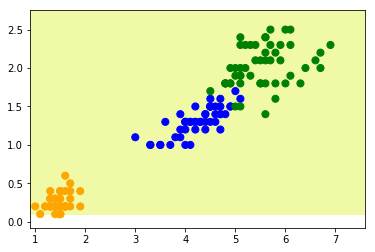

#20 [[3.07656328 1.09023238]] [[0.]] 0.6666666666666666


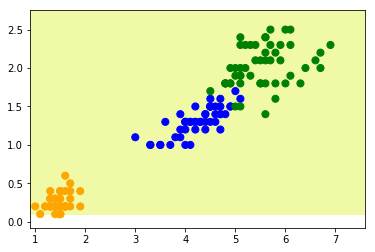

#40 [[5.80189661 2.27823238]] [[0.]] 0.6666666666666666


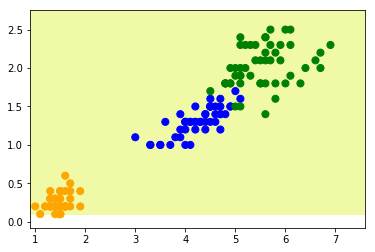

#60 [[8.52722995 3.46623238]] [[0.]] 0.6666666666666666


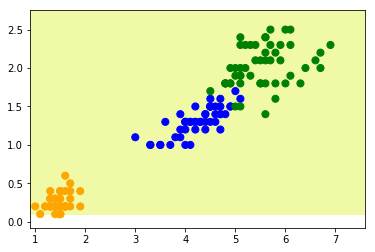

#80 [[11.25256328  4.65423238]] [[0.]] 0.6666666666666666


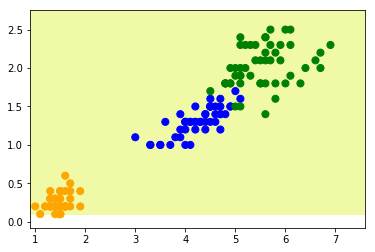

#100 [[13.97789661  5.84223238]] [[0.]] 0.6666666666666666


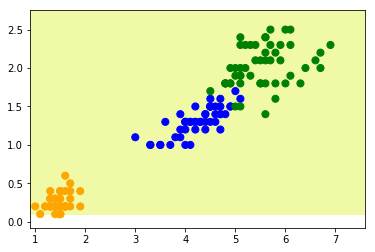

#120 [[16.70322995  7.03023238]] [[0.]] 0.6666666666666666


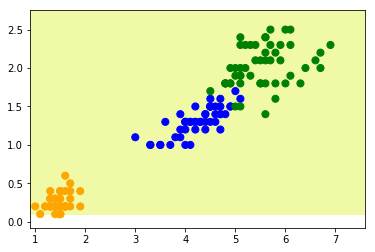

#140 [[19.42856328  8.21823238]] [[0.]] 0.6666666666666666


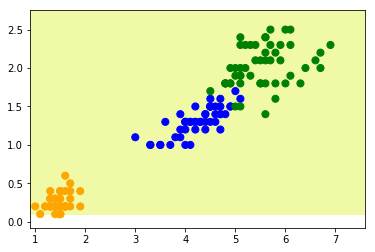

#160 [[22.15389661  9.40623238]] [[0.]] 0.6666666666666666


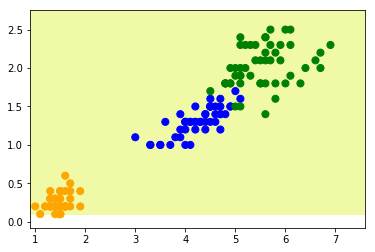

#180 [[24.87922995 10.59423238]] [[0.]] 0.6666666666666666


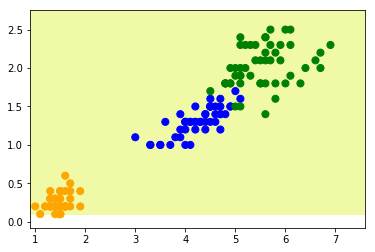

#0 [[27.60456328 11.78223238]] [[0.]] 0.6666666666666666


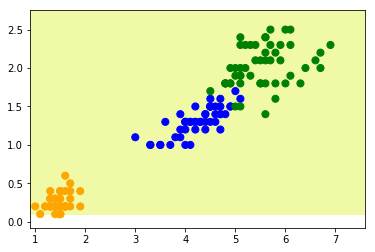

(0.6666666666666666, 0)

In [7]:
iris=np.loadtxt('iris.csv', delimiter=',')
X=iris[:,0:4].T
T=iris[:,4]

from matplotlib import pyplot as plt
plt.ion()
plt.figure()

sln = SLN(2,1)
sln.DeltaTrain(X[-2:,:],T,0.1,200,0.0)